# Generative Adversarial Network

![image.png](https://drive.google.com/uc?id=14dvHA0WHmMhbvs0xz_GVQ3I268BMs6LL)

# Load Libraries

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.layers import Activation, Dense, Reshape, UpSampling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
import math


# Load Dataset in Numpy Format

MNIST is a simple computer vision dataset. It consists of images of handwritten digits. It also includes labels for each image, telling us which digit it is. The MNIST data is split into three parts: 60,000 data points of training data, and 10,000 points of test data. Each image is 28 pixels by 28 pixels.

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data() # 10000*28*28  #10000

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_train.shape

(60000, 28, 28)

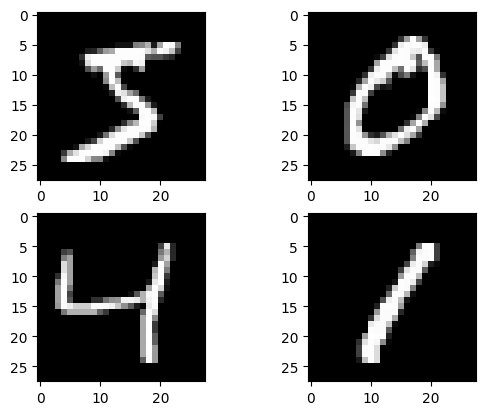

In [4]:
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

# Formatting Data for Keras

In [5]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train = X_train[:,:,:,np.newaxis] # 60000, 28, 28, 1
X_test = X_test[:,:,:,np.newaxis] # 10000, 28, 28, 1

# Defining Generator function

In [6]:
def generator_model():
    model = Sequential()
    model.add(Dense(1024, input_dim=100)) #100 --- 1024
    model.add(Activation('relu'))
    model.add(Dense(128*7*7)) #1024 -> 128*7*7 = N
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,))) # 7,7, 128
    model.add(UpSampling2D(size=(2, 2))) # 14, 14, 128
    model.add(Conv2D(64, (5, 5), padding='same')) # 14, 14, 64
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2, 2))) # 28, 28, 64
    model.add(Conv2D(1, (5, 5), padding='same')) # 28, 28, 1
    model.add(Activation('sigmoid'))
    return model

g = generator_model()
print(g.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              103424    
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 6272)              6428800   
                                                                 
 activation_1 (Activation)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                        

# Defining Discriminator function

In [7]:
def discriminator_model():
    model = Sequential()
    model.add(
            Conv2D(64, (5, 5),
            padding='same',
            input_shape=(28, 28, 1))
            )
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) # 14, 14, 64
    model.add(Conv2D(128, (5, 5))) # 14, 14, 128
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) # 7, 7, 128
    model.add(Flatten()) # 7*7*128
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(1)) #
    model.add(Activation('sigmoid')) # 0.63 # 1- 0.63 = 0.37
    return model

d = discriminator_model()

print(d.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 activation_4 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)       204928    
                                                                 
 activation_5 (Activation)   (None, 10, 10, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                 

# Defining GAN Model

In [9]:
def generator_containing_discriminator(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

d_on_g = generator_containing_discriminator(g, d)

In [10]:
#opt = Adam(lr=0.0002, beta_1=0.5)
BATCH_SIZE = 128
#g.compile(loss='binary_crossentropy', optimizer=adam)
d_on_g.compile(loss='binary_crossentropy', optimizer='sgd')
d.compile(loss='binary_crossentropy', optimizer='sgd')

# Training the GAN

In [11]:
for epoch in range(20):
    print("Epoch is", epoch)
    print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
    for index in range(int(X_train.shape[0]/BATCH_SIZE)):
        noise = np.random.normal(0, 1, size=(BATCH_SIZE, 100)) #128 * 100
        image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE] # 128, 28, 28
        generated_images = g.predict(noise) # 128, 100 = 128, 28 , 28, 1
        X = np.concatenate((image_batch, generated_images)) # 256, 28, 28,1
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE # 256, 1
        y = np.asarray(y)
        d_loss = d.train_on_batch(X, y)
        print("batch %d d_loss : %f" % (index, d_loss))
        noise = np.random.normal(0, 1, size=(BATCH_SIZE, 100)) # 128, 100
        #d.trainable = False
        g_loss = d_on_g.train_on_batch(noise, np.asarray([1] * BATCH_SIZE))
        d.trainable = True
        print("batch %d g_loss : %f" % (index, g_loss))

Epoch is 0
Number of batches 468
4/4 [==============================] - 2s 3ms/step
batch 0 d_loss : 0.689228
batch 0 g_loss : 0.717153
4/4 [==============================] - 0s 3ms/step
batch 1 d_loss : 0.689724
batch 1 g_loss : 0.717260
4/4 [==============================] - 0s 2ms/step
batch 2 d_loss : 0.688797
batch 2 g_loss : 0.717218
4/4 [==============================] - 0s 3ms/step
batch 3 d_loss : 0.689555
batch 3 g_loss : 0.717170
4/4 [==============================] - 0s 3ms/step
batch 4 d_loss : 0.690677
batch 4 g_loss : 0.717145
4/4 [==============================] - 0s 2ms/step
batch 5 d_loss : 0.689769
batch 5 g_loss : 0.717137
4/4 [==============================] - 0s 3ms/step
batch 6 d_loss : 0.689242
batch 6 g_loss : 0.717113
4/4 [==============================] - 0s 2ms/step
batch 7 d_loss : 0.690180
batch 7 g_loss : 0.717112
4/4 [==============================] - 0s 2ms/step
batch 8 d_loss : 0.689156
batch 8 g_loss : 0.716985
4/4 [==============================] - 0

KeyboardInterrupt: ignored

# Generate images

1/1 [==============================] - 0s 239ms/step
Predicted images


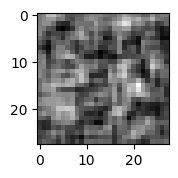

In [12]:
noise = np.random.randn(20*100)
noise = noise.reshape(20, 100)
generated_images = g.predict(noise)
generated_images = generated_images.reshape(20,28,28)
generated_images = (generated_images * 255)

plt.figure(figsize=(20, 4))
print("Predicted images")
for i in range(7,8,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(generated_images[i,:,:], cmap='gray')
plt.show()